In [544]:
import os
import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import TimeseriesGenerator


mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.grid'] = False
plt.style.use('ggplot')

In [545]:

data_2 = pd.read_csv('../output/zero4_outputs.csv')
data_2 = data_2.drop([data_2.columns[0]], axis='columns')
data_2 = data_2.iloc[:, :-3]
data_2.reset_index(drop=True, inplace=True)
# unit='s' to convert it into epoch time
data_2['Time'] = pd.to_datetime(data_2['Time'])

date_time = data_2['Time'].dt.strftime('%S')


# checking our dataframe once again
data_2.head()


,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_49,Subcar_50,Subcar_51,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58
0,1970-01-01 00:00:01.641598542,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,575.782077,520.239368,471.936436,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079
1,1970-01-01 00:00:01.641598543,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,455.247186,423.709806,390.858030,367.766230,339.484904,339.087010,343.083080,343.739727,346.943800,351.039884
2,1970-01-01 00:00:01.641598544,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,672.899695,599.141052,524.108767,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791
3,1970-01-01 00:00:01.641598545,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,610.351538,538.108725,508.141712,459.243944,413.706418,406.503382,392.998728,389.802514,381.072172,390.508643
4,1970-01-01 00:00:01.641598546,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,788.428817,729.188590,698.148981,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355


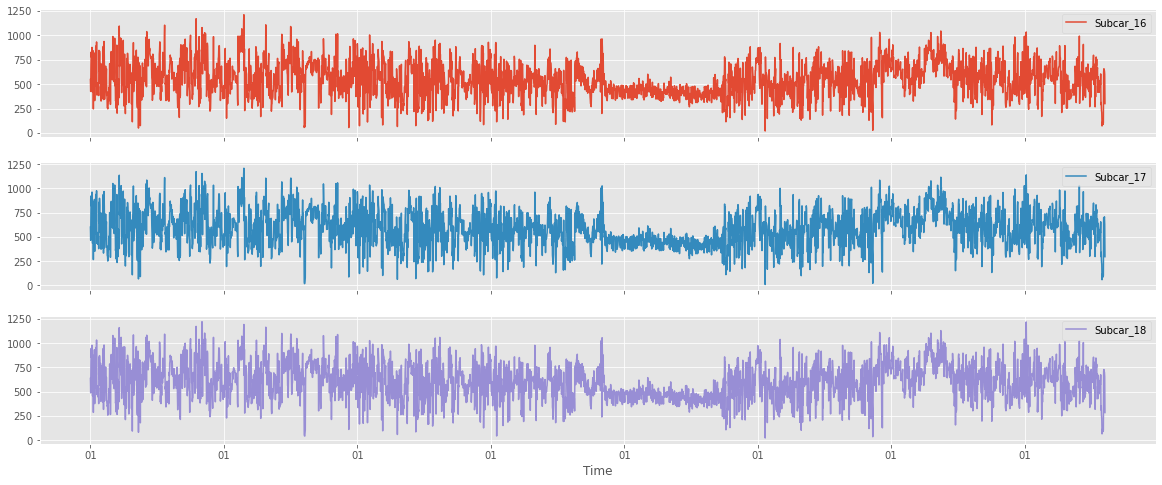

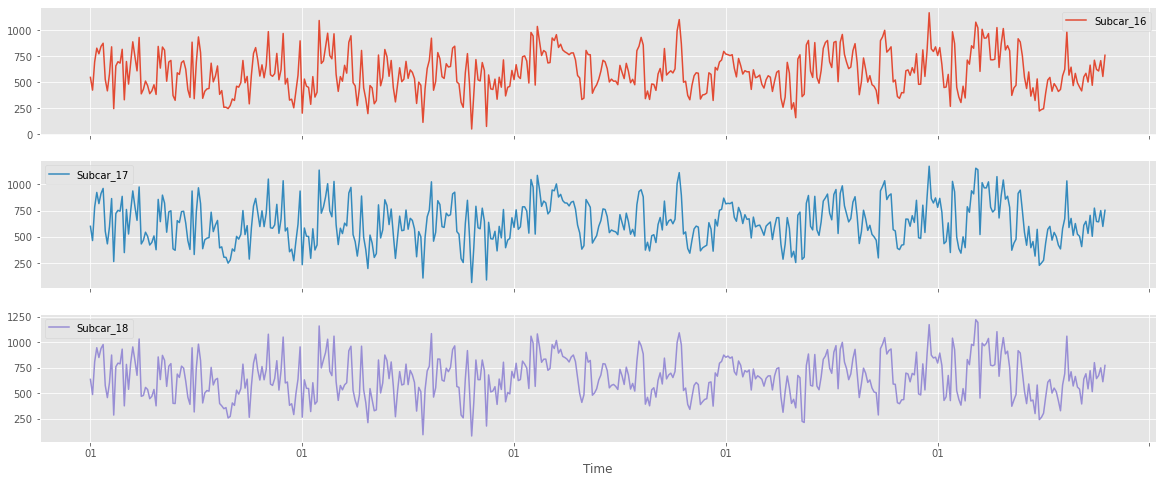

In [546]:
plot_cols = ['Subcar_16', 'Subcar_17', 'Subcar_18']
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)
# plt.savefig('../images/raw_data_1.png', dpi=500,)

plot_features = data_2[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)
# plt.savefig('../images/raw_data_2.png', dpi=500,)



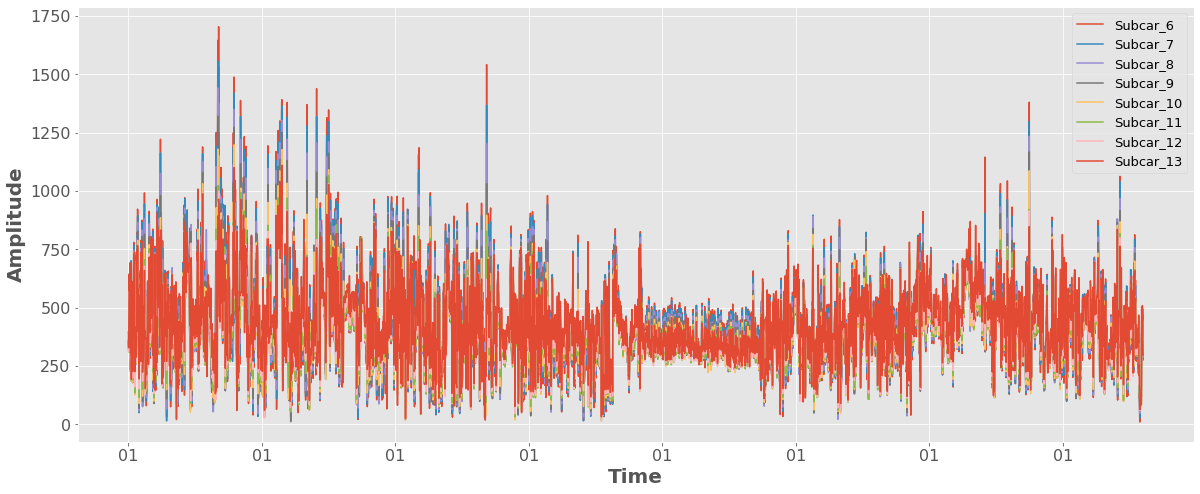

In [547]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_8', 'Subcar_9',
             'Subcar_10', 'Subcar_11', 'Subcar_12', 'Subcar_13']
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold', horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=13)
# plt.savefig('../images/raw_data.pdf', dpi=300)


In [548]:
# Set the date column as the index of your DataFrame meat
data_2 = data_2.set_index('Time')

# Print the summary statistics of the DataFrame
print(data_2.describe())


          Subcar_0     Subcar_1     Subcar_2     Subcar_3     Subcar_4  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000   
mean   5482.579092  7455.158795  6233.369403  8730.690589   437.319876   
std     308.541115   114.541341    63.095344   167.604655   494.960094   
min       0.000000  5499.938181  6230.129694  6230.129694     6.000000   
25%    5499.938181  7461.867126  6230.129694  8741.921642   277.672016   
50%    5499.938181  7461.867126  6230.129694  8741.921642   379.214319   
75%    5499.938181  7461.867126  6230.129694  8741.921642   502.360387   
max    5499.938181  7461.867126  7461.867126  8741.921642  8741.921642   

          Subcar_5     Subcar_6     Subcar_7     Subcar_8     Subcar_9  ...  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000  ...   
mean    418.955691   422.932055   422.431979   413.767333   410.627681  ...   
std     208.937454   202.453002   193.543158   181.690717   171.775869  ...   
min       4.24264

In [549]:
df_input = data_2[['Subcar_6', 'Subcar_7', 'Subcar_8', 'Subcar_9',
                   'Subcar_10', 'Subcar_11', 'Subcar_12', 'Subcar_13']]
df_input.head()


,Subcar_6,Subcar_7,Subcar_8,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_13
Time,,,,,,,,
1970-01-01 00:00:01.641598542,362.527240,353.411941,351.432782,353.793725,347.315419,349.905702,369.545667,396.717784
1970-01-01 00:00:01.641598543,338.013313,332.434956,327.232333,319.820262,315.317300,310.386855,313.359219,328.671569
1970-01-01 00:00:01.641598544,421.911128,424.001179,447.754397,441.279957,441.367194,461.677376,465.649009,500.372861
1970-01-01 00:00:01.641598545,533.348854,545.424605,542.492396,562.694411,538.674299,580.400724,591.622346,644.920150
1970-01-01 00:00:01.641598546,415.226444,450.480854,445.583887,458.423385,479.883319,511.391240,527.319637,571.505031


In [550]:
df_input.describe()


,Subcar_6,Subcar_7,Subcar_8,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_13
count,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000
mean,422.932055,422.431979,413.767333,410.627681,403.013887,401.351757,409.075167,432.789300
std,202.453002,193.543158,181.690717,171.775869,160.406865,152.042491,149.184960,151.963799
min,10.295630,14.764823,24.207437,11.661904,19.235384,17.029386,14.317821,21.023796
25%,295.032201,300.879956,300.189524,301.906856,299.537560,302.426850,310.169711,330.353976
50%,391.523942,393.309005,389.432916,387.431284,381.450521,381.629371,392.020408,416.394643
75%,511.462363,509.395703,500.228934,496.494461,487.182967,486.122154,497.416318,525.755407
max,1704.556541,1556.767484,1442.231951,1320.984860,1198.269586,1101.918781,1104.339169,1110.358951


In [551]:
df_input.query("Subcar_8 > 511")


,Subcar_6,Subcar_7,Subcar_8,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_13
Time,,,,,,,,
1970-01-01 00:00:01.641598545,533.348854,545.424605,542.492396,562.694411,538.674299,580.400724,591.622346,644.920150
1970-01-01 00:00:01.641598547,602.844093,587.749096,612.885797,601.239553,597.501464,612.315278,607.217424,648.398797
1970-01-01 00:00:01.641598547,639.425523,635.824661,629.924599,631.708794,623.773196,629.221742,638.401128,692.788568
1970-01-01 00:00:01.641598550,691.112871,701.485567,678.552135,677.784627,655.331977,646.693900,654.083328,689.844185
1970-01-01 00:00:01.641598556,780.515855,768.584413,745.410625,730.010959,708.801806,698.401747,700.925103,724.347983
...,...,...,...,...,...,...,...,...
1970-01-01 00:00:01.641600103,615.646814,626.744765,609.397243,609.118215,588.809817,588.217647,581.749087,609.899992
1970-01-01 00:00:01.641600103,690.676480,678.564662,658.891493,656.966514,620.133050,616.235345,615.601332,648.617761
1970-01-01 00:00:01.641600104,521.008637,531.681296,523.841579,533.258849,523.495941,529.429882,522.215473,552.109591


In [552]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_input)
data_scaled


array([[-0.29840387, -0.35666007, -0.34312568, ..., -0.33841081,
        -0.26500459, -0.23740037],
       [-0.41950433, -0.46505834, -0.47633904, ..., -0.59836475,
        -0.64167687, -0.68523838],
       [-0.00504345,  0.00810882,  0.1870846 , ...,  0.39682035,
         0.37926936,  0.44479311],
       ...,
       [-0.27743919, -0.20720092, -0.15398159, ...,  0.13881481,
         0.2616766 ,  0.50162977],
       [-0.73269987, -0.72525887, -0.70052711, ..., -0.21866316,
        -0.05965833,  0.04077753],
       [ 0.34273106,  0.22060855,  0.14296075, ..., -0.33748043,
        -0.6623704 , -0.8857198 ]])

In [553]:
features = data_scaled
target = data_scaled[:, 1]


In [554]:
TimeseriesGenerator(features, target, length=6,
                    sampling_rate=1, batch_size=1)[1]


(array([[[-0.41950433, -0.46505834, -0.47633904, -0.52870851,
          -0.54678534, -0.59836475, -0.64167687, -0.68523838],
         [-0.00504345,  0.00810882,  0.1870846 ,  0.1784669 ,
           0.23913161,  0.39682035,  0.37926936,  0.44479311],
         [ 0.54546646,  0.63556266,  0.70857773,  0.88537891,
           0.84583821,  1.17777942,  1.22379086,  1.39611377],
         [-0.03806624,  0.14494217,  0.17513684,  0.27828118,
           0.47927839,  0.72383684,  0.79270742,  0.91294096],
         [ 0.88877764,  0.85427387,  1.09606401,  1.1098005 ,
           1.21262366,  1.38771253,  1.3283398 ,  1.41900807],
         [ 1.06949239,  1.10270367,  1.1898555 ,  1.28720172,
           1.37642705,  1.4989228 ,  1.53739443,  1.71115403]]]),
 array([-0.32164054]))

In [555]:
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.20, random_state=120, shuffle=False)
print('X_train.shape: ', x_train.shape)
print('X_test.shape: ', x_test.shape)


X_train.shape:  (3041, 8)
X_test.shape:  (761, 8)


In [556]:
win_length = 144  # 1 day = 144 of data, 5 day = 720 of data
batch_size = 32
num_features = 8
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [557]:
train_generator[0]


(array([[[-0.29840387, -0.35666007, -0.34312568, ..., -0.33841081,
          -0.26500459, -0.23740037],
         [-0.41950433, -0.46505834, -0.47633904, ..., -0.59836475,
          -0.64167687, -0.68523838],
         [-0.00504345,  0.00810882,  0.1870846 , ...,  0.39682035,
           0.37926936,  0.44479311],
         ...,
         [-0.31770112, -0.29853529, -0.22009508, ..., -0.10322539,
          -0.04825732,  0.02566327],
         [-0.17366199, -0.13916572, -0.01731661, ...,  0.28120564,
           0.44161232,  0.58151438],
         [-1.93023053, -2.10609108, -1.91410552, ..., -1.48548299,
          -1.18161159, -1.07081773]],
 
        [[-0.41950433, -0.46505834, -0.47633904, ..., -0.59836475,
          -0.64167687, -0.68523838],
         [-0.00504345,  0.00810882,  0.1870846 , ...,  0.39682035,
           0.37926936,  0.44479311],
         [ 0.54546646,  0.63556266,  0.70857773, ...,  1.17777942,
           1.22379086,  1.39611377],
         ...,
         [-0.17366199, -0.1391657

In [558]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(
        win_length, num_features), return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, 'linear')
])

lstm_model.summary()


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 144, 128)          70144     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 144, 128)          0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 144, 128)          131584    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 144, 128)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 144, 128)          0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)              

In [559]:
cp1 = ModelCheckpoint('../save/lstm_model_standard/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}

In [560]:
history = lstm_model.fit(
    train_generator, epochs=15,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp1 ])


Epoch 1/15
91/91 [==============================] - 40s 437ms/step - loss: 0.9630 - mean_absolute_error: 0.7172 - val_loss: 0.6070 - val_mean_absolute_error: 0.5935
Epoch 2/15
91/91 [==============================] - 38s 417ms/step - loss: 0.8839 - mean_absolute_error: 0.6882 - val_loss: 0.5866 - val_mean_absolute_error: 0.5793
Epoch 3/15
91/91 [==============================] - 38s 418ms/step - loss: 0.8436 - mean_absolute_error: 0.6690 - val_loss: 0.5658 - val_mean_absolute_error: 0.5672
Epoch 4/15
91/91 [==============================] - 38s 415ms/step - loss: 0.8100 - mean_absolute_error: 0.6541 - val_loss: 0.5513 - val_mean_absolute_error: 0.5571
Epoch 5/15
91/91 [==============================] - 30s 329ms/step - loss: 0.7835 - mean_absolute_error: 0.6405 - val_loss: 0.5514 - val_mean_absolute_error: 0.5605
Epoch 6/15
91/91 [==============================] - 38s 414ms/step - loss: 0.7719 - mean_absolute_error: 0.6321 - val_loss: 0.5497 - val_mean_absolute_error: 0.5584
Epoch 7/15

In [561]:
lstm_eval = lstm_model.evaluate(
    test_generator, verbose=0
)
lstm_eval
val_performance['LSTM'] = lstm_model.evaluate(train_generator)
performance['LSTM'] = lstm_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 19s 207ms/step - loss: 0.7854 - mean_absolute_error: 0.6419


In [562]:
predictions_lstm = lstm_model.predict(test_generator)

In [563]:
from tensorflow.keras.models import load_model
gru_model = load_model('../save/lstm_model_standard/')

In [564]:
predictions_lstm.shape[0]


617

In [565]:
predictions_lstm


array([[ 0.33694568],
       [ 0.4572428 ],
       [ 0.62567544],
       [ 0.59055966],
       [ 0.6826902 ],
       [ 0.39438227],
       [ 0.29129115],
       [ 0.33638516],
       [ 0.4767364 ],
       [ 0.46572182],
       [ 0.3594762 ],
       [ 0.45430437],
       [ 0.5073389 ],
       [ 0.25924936],
       [ 0.05600056],
       [ 0.04135692],
       [ 0.1056474 ],
       [ 0.27505252],
       [ 0.3570765 ],
       [ 0.21439417],
       [ 0.26073667],
       [ 0.15838605],
       [ 0.11049783],
       [-0.02377823],
       [-0.03797316],
       [ 0.37611097],
       [-0.04316746],
       [-0.0966645 ],
       [-0.13430266],
       [-0.03268376],
       [-0.00146289],
       [ 0.0241942 ],
       [ 0.04465103],
       [ 0.09594728],
       [ 0.12795204],
       [ 0.16287516],
       [ 0.05437565],
       [ 0.01029218],
       [ 0.08806089],
       [ 0.04436085],
       [ 0.10813808],
       [ 0.11745012],
       [ 0.11419994],
       [ 0.05367815],
       [ 0.06168595],
       [-0

In [566]:
y_test


array([-1.78006675e-01,  2.90522982e-01,  4.01932093e-01, -3.79251433e-01,
       -2.99279395e-01, -2.78792655e-01, -2.98110214e-01, -2.81164148e-01,
       -2.22417265e-01, -1.07808395e+00, -8.15801157e-01,  5.79954518e-01,
       -6.86622939e-01, -4.95420527e-01,  5.30510897e-01,  4.63250208e-01,
       -1.25570378e-01,  8.39427469e-01,  1.14431566e+00, -8.61278758e-02,
       -1.55122403e-01, -6.67327547e-02, -6.07852007e-02,  1.09177878e+00,
        4.27697261e-01, -5.62510972e-01,  6.83577733e-02,  6.59699164e-01,
       -5.97099194e-01, -7.06773017e-01, -3.14681106e-01, -7.99520204e-01,
       -5.33956905e-01, -5.62716976e-01, -3.53351252e-01, -3.56915968e-01,
       -2.15191286e-01, -2.60981634e-01,  4.54835917e-01,  3.74158938e-01,
       -1.19796188e-01, -1.05337742e-01, -5.84620349e-01, -2.10494719e-01,
        5.95663698e-01,  3.54550545e-01,  2.65081183e-01, -4.86511378e-01,
        1.44002703e+00, -1.32841472e+00,  4.04121247e-01, -4.74652685e-01,
        2.65321149e-01,  

In [567]:
x_test


array([[-0.22339246, -0.17800668, -0.13104803, ..., -0.05999742,
        -0.08727465, -0.04337781],
       [ 0.26046697,  0.29052298,  0.33157891, ...,  0.40224399,
         0.50468923,  0.55009563],
       [ 0.30468378,  0.40193209,  0.34824829, ...,  0.53355755,
         0.55595968,  0.6302058 ],
       ...,
       [-0.27743919, -0.20720092, -0.15398159, ...,  0.13881481,
         0.2616766 ,  0.50162977],
       [-0.73269987, -0.72525887, -0.70052711, ..., -0.21866316,
        -0.05965833,  0.04077753],
       [ 0.34273106,  0.22060855,  0.14296075, ..., -0.33748043,
        -0.6623704 , -0.8857198 ]])

In [568]:
x_test[:, 1:][win_length:]


array([[ 1.0241705 ,  1.18165347,  1.22346867, ...,  1.41624103,
         1.43584558,  1.5599212 ],
       [ 1.29962917,  1.68203068,  1.64645577, ...,  1.9655386 ,
         2.25285341,  2.25943191],
       [ 1.25468271,  1.39370489,  1.4411265 , ...,  1.73023853,
         1.81978041,  1.91960807],
       ...,
       [-0.20720092, -0.15398159,  0.07324638, ...,  0.13881481,
         0.2616766 ,  0.50162977],
       [-0.72525887, -0.70052711, -0.52228415, ..., -0.21866316,
        -0.05965833,  0.04077753],
       [ 0.22060855,  0.14296075, -0.015185  , ..., -0.33748043,
        -0.6623704 , -0.8857198 ]])

In [569]:
df_pred_lstm = pd.concat([pd.DataFrame(predictions_lstm),
                    pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_lstm


,0,0,1,2,3,4,5,6
0,0.336946,1.024170,1.181653,1.223469,1.269134,1.416241,1.435846,1.559921
1,0.457243,1.299629,1.682031,1.646456,2.078127,1.965539,2.252853,2.259432
2,0.625675,1.254683,1.393705,1.441127,1.537556,1.730239,1.819780,1.919608
3,0.590560,1.428023,1.518551,1.610747,1.758643,1.849356,1.960043,2.127451
4,0.682690,0.593265,0.585529,0.664491,0.666645,0.833811,0.888136,0.934638
...,...,...,...,...,...,...,...,...
612,0.064002,-0.139950,-0.002518,0.078249,0.131267,0.109520,0.388319,0.443826
613,0.210867,-0.213699,-0.106270,-0.033622,0.061901,0.245970,0.274389,0.358970
614,0.140419,-0.207201,-0.153982,0.073246,0.072636,0.138815,0.261677,0.501630
615,0.048516,-0.725259,-0.700527,-0.522284,-0.357670,-0.218663,-0.059658,0.040778


In [570]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred_lstm)
rev_trans


array([[491.13874873, 620.6271022 , 628.434563  , ..., 616.6522521 ,
        623.25356   , 669.8096745 ],
       [515.49005557, 673.9332311 , 719.3364998 , ..., 700.1578393 ,
        745.1228087 , 776.0959992 ],
       [549.58526711, 665.2352967 , 666.95727   , ..., 664.3869355 ,
        680.523328  , 724.4618693 ],
       ...,
       [451.35647233, 382.3349317 , 385.7939865 , ..., 422.4547313 ,
        448.1082459 , 509.0088408 ],
       [432.75289671, 282.0815485 , 286.5047993 , ..., 368.1100379 ,
        400.1762112 , 438.9851934 ],
       [392.62285414, 465.1236395 , 439.7385587 , ..., 350.0471397 ,
        310.2724609 , 298.2096578 ]])

In [571]:
df_final_lstm = df_input[predictions_lstm.shape[0]*-1:]


In [572]:
df_final_lstm.count()


Subcar_6     617
Subcar_7     617
Subcar_8     617
Subcar_9     617
Subcar_10    617
Subcar_11    617
Subcar_12    617
Subcar_13    617
dtype: int64

In [573]:
df_final_lstm['Subcar_8_pred'] = rev_trans[:, 1]
df_final_lstm


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_8,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_13,Subcar_8_pred
Time,,,,,,,,,
1970-01-01 00:00:01.641599862,603.491508,620.627102,628.434563,620.762434,606.564918,616.652252,623.253560,669.809675,620.627102
1970-01-01 00:00:01.641599862,647.734514,673.933231,719.336500,693.411855,736.315829,700.157839,745.122809,776.095999,673.933231
1970-01-01 00:00:01.641599862,656.558451,665.235297,666.957270,658.145880,649.616040,664.386936,680.523328,724.461869,665.235297
1970-01-01 00:00:01.641599862,703.184186,698.779651,689.637586,687.278692,685.075178,682.495421,701.445650,756.042327,698.779651
1970-01-01 00:00:01.641599862,547.154457,537.239239,520.138443,524.756134,509.934309,528.109837,541.554245,574.801705,537.239239
...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:01.641600115,369.043358,395.349213,413.309811,424.067212,424.067212,418.001196,466.998929,500.225949,395.349213
1970-01-01 00:00:01.641600115,362.663756,381.077420,394.461658,404.853060,412.941885,438.744800,450.004444,487.332535,381.077420
1970-01-01 00:00:01.641600115,366.771046,382.334932,385.793987,423.207987,414.663719,422.454731,448.108246,509.008841,382.334932


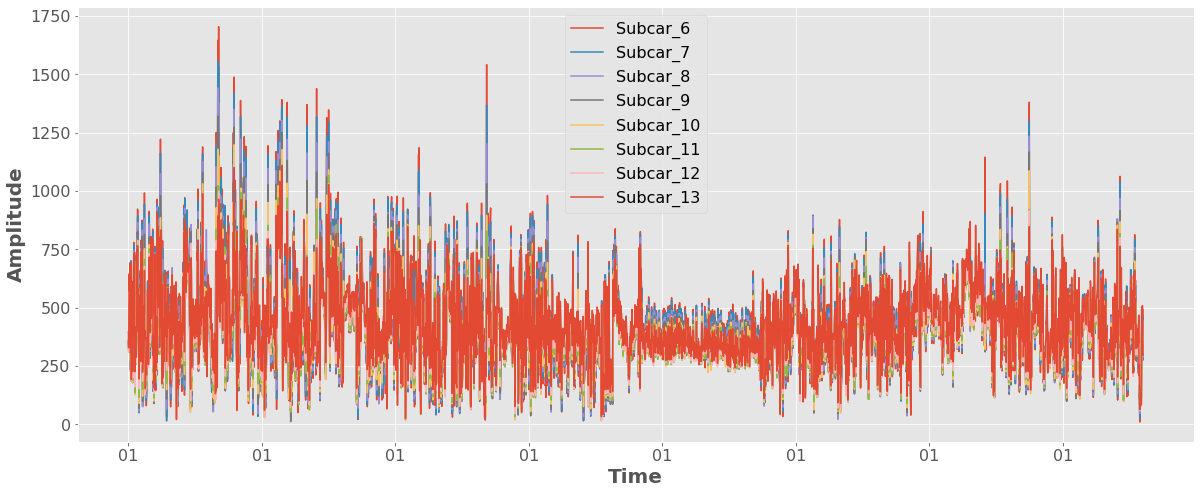

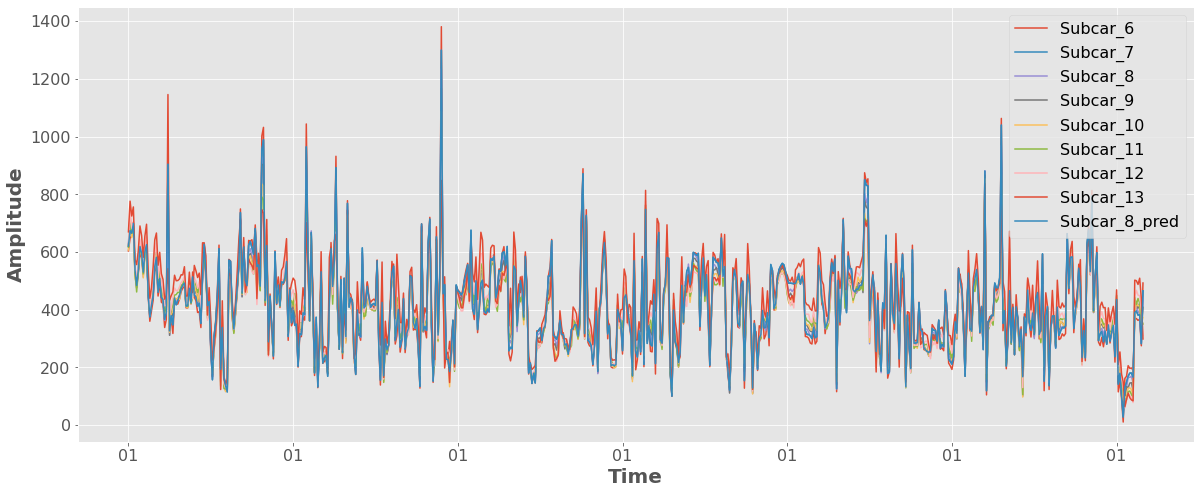

In [575]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_8', 'Subcar_9',
             'Subcar_10', 'Subcar_11', 'Subcar_12', 'Subcar_13']
plot_features = df_input[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# plt.savefig('../images/raw_standard.png', dpi=500)


df_final_lstm[['Subcar_8', 'Subcar_8_pred']]
df_final_lstm.index = date_time[:617]
_ = df_final_lstm.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# plt.savefig('../images/pred_standard.png', dpi=500)


In [576]:
gru_model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        128, input_shape=(win_length, num_features), return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])


In [577]:
cp3 = ModelCheckpoint('../save/gru_model_standard/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
gru_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [578]:
history_2 = gru_model.fit(
    train_generator, epochs=10,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping
               , cp3])


Epoch 1/10
91/91 [==============================] - 54s 592ms/step - loss: 0.9732 - mean_absolute_error: 0.7104 - val_loss: 0.5941 - val_mean_absolute_error: 0.5837
Epoch 2/10
91/91 [==============================] - 53s 585ms/step - loss: 0.8823 - mean_absolute_error: 0.6784 - val_loss: 0.5895 - val_mean_absolute_error: 0.5779
Epoch 3/10
91/91 [==============================] - 57s 625ms/step - loss: 0.8343 - mean_absolute_error: 0.6628 - val_loss: 0.5770 - val_mean_absolute_error: 0.5691
Epoch 4/10
91/91 [==============================] - 54s 596ms/step - loss: 0.8097 - mean_absolute_error: 0.6527 - val_loss: 0.5728 - val_mean_absolute_error: 0.5655
Epoch 5/10
91/91 [==============================] - 57s 629ms/step - loss: 0.7932 - mean_absolute_error: 0.6447 - val_loss: 0.5702 - val_mean_absolute_error: 0.5630
Epoch 6/10
91/91 [==============================] - 57s 621ms/step - loss: 0.7816 - mean_absolute_error: 0.6390 - val_loss: 0.5685 - val_mean_absolute_error: 0.5621
Epoch 7/10

In [ ]:
from tensorflow.keras.models import load_model
gru_model = load_model('../save/gru_model_standard/')

In [579]:
gru_eval = gru_model.evaluate(
    test_generator, verbose=0
)
gru_eval
val_performance['BiLSTM'] = lstm_model.evaluate(train_generator)
performance['BiLSTM'] = lstm_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 20s 219ms/step - loss: 0.7854 - mean_absolute_error: 0.6419


In [580]:
predictions_gru = gru_model.predict(test_generator)
predictions_gru

array([[ 0.32465252],
       [ 0.4677005 ],
       [ 0.6789411 ],
       [ 0.7579613 ],
       [ 0.8630681 ],
       [ 0.6680063 ],
       [ 0.4812505 ],
       [ 0.44733045],
       [ 0.555423  ],
       [ 0.5883626 ],
       [ 0.50539863],
       [ 0.56992525],
       [ 0.63501155],
       [ 0.4342887 ],
       [ 0.17103569],
       [ 0.07261999],
       [ 0.07960626],
       [ 0.2229726 ],
       [ 0.3414065 ],
       [ 0.25619712],
       [ 0.2757211 ],
       [ 0.18834691],
       [ 0.11620207],
       [-0.01963713],
       [-0.04243952],
       [ 0.37772977],
       [ 0.135902  ],
       [ 0.07094564],
       [-0.01763211],
       [ 0.02509603],
       [ 0.04615014],
       [ 0.06392389],
       [ 0.08890994],
       [ 0.149318  ],
       [ 0.19930601],
       [ 0.24647401],
       [ 0.1328129 ],
       [ 0.0541581 ],
       [ 0.11097129],
       [ 0.06238502],
       [ 0.11588345],
       [ 0.11563124],
       [ 0.1157259 ],
       [ 0.08082208],
       [ 0.08306645],
       [-0

In [581]:
predictions_gru.shape[0]


617

In [582]:
predictions_gru

array([[ 0.32465252],
       [ 0.4677005 ],
       [ 0.6789411 ],
       [ 0.7579613 ],
       [ 0.8630681 ],
       [ 0.6680063 ],
       [ 0.4812505 ],
       [ 0.44733045],
       [ 0.555423  ],
       [ 0.5883626 ],
       [ 0.50539863],
       [ 0.56992525],
       [ 0.63501155],
       [ 0.4342887 ],
       [ 0.17103569],
       [ 0.07261999],
       [ 0.07960626],
       [ 0.2229726 ],
       [ 0.3414065 ],
       [ 0.25619712],
       [ 0.2757211 ],
       [ 0.18834691],
       [ 0.11620207],
       [-0.01963713],
       [-0.04243952],
       [ 0.37772977],
       [ 0.135902  ],
       [ 0.07094564],
       [-0.01763211],
       [ 0.02509603],
       [ 0.04615014],
       [ 0.06392389],
       [ 0.08890994],
       [ 0.149318  ],
       [ 0.19930601],
       [ 0.24647401],
       [ 0.1328129 ],
       [ 0.0541581 ],
       [ 0.11097129],
       [ 0.06238502],
       [ 0.11588345],
       [ 0.11563124],
       [ 0.1157259 ],
       [ 0.08082208],
       [ 0.08306645],
       [-0

In [583]:
df_pred_gru = pd.concat([pd.DataFrame(predictions_gru),
                    pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_gru

,0,0,1,2,3,4,5,6
0,0.324653,1.024170,1.181653,1.223469,1.269134,1.416241,1.435846,1.559921
1,0.467701,1.299629,1.682031,1.646456,2.078127,1.965539,2.252853,2.259432
2,0.678941,1.254683,1.393705,1.441127,1.537556,1.730239,1.819780,1.919608
3,0.757961,1.428023,1.518551,1.610747,1.758643,1.849356,1.960043,2.127451
4,0.863068,0.593265,0.585529,0.664491,0.666645,0.833811,0.888136,0.934638
...,...,...,...,...,...,...,...,...
612,-0.164077,-0.139950,-0.002518,0.078249,0.131267,0.109520,0.388319,0.443826
613,0.026836,-0.213699,-0.106270,-0.033622,0.061901,0.245970,0.274389,0.358970
614,0.085041,-0.207201,-0.153982,0.073246,0.072636,0.138815,0.261677,0.501630
615,0.076806,-0.725259,-0.700527,-0.522284,-0.357670,-0.218663,-0.059658,0.040778


In [584]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred_gru)
rev_trans


array([[488.65028891, 620.6271022 , 628.434563  , ..., 616.6522521 ,
        623.25356   , 669.8096745 ],
       [517.6069748 , 673.9332311 , 719.3364998 , ..., 700.1578393 ,
        745.1228087 , 776.0959992 ],
       [560.3676358 , 665.2352967 , 666.95727   , ..., 664.3869355 ,
        680.523328  , 724.4618693 ],
       ...,
       [440.14653817, 382.3349317 , 385.7939865 , ..., 422.4547313 ,
        448.1082459 , 509.0088408 ],
       [438.47963839, 282.0815485 , 286.5047993 , ..., 368.1100379 ,
        400.1762112 , 438.9851934 ],
       [403.34021816, 465.1236395 , 439.7385587 , ..., 350.0471397 ,
        310.2724609 , 298.2096578 ]])

In [585]:
df_final_gru = df_input[predictions_gru.shape[0]*-1:]

In [586]:
df_final_gru['Subcar_8_pred'] = rev_trans[:, 1]
df_final_gru


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_8,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_13,Subcar_8_pred
Time,,,,,,,,,
1970-01-01 00:00:01.641599862,603.491508,620.627102,628.434563,620.762434,606.564918,616.652252,623.253560,669.809675,620.627102
1970-01-01 00:00:01.641599862,647.734514,673.933231,719.336500,693.411855,736.315829,700.157839,745.122809,776.095999,673.933231
1970-01-01 00:00:01.641599862,656.558451,665.235297,666.957270,658.145880,649.616040,664.386936,680.523328,724.461869,665.235297
1970-01-01 00:00:01.641599862,703.184186,698.779651,689.637586,687.278692,685.075178,682.495421,701.445650,756.042327,698.779651
1970-01-01 00:00:01.641599862,547.154457,537.239239,520.138443,524.756134,509.934309,528.109837,541.554245,574.801705,537.239239
...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:01.641600115,369.043358,395.349213,413.309811,424.067212,424.067212,418.001196,466.998929,500.225949,395.349213
1970-01-01 00:00:01.641600115,362.663756,381.077420,394.461658,404.853060,412.941885,438.744800,450.004444,487.332535,381.077420
1970-01-01 00:00:01.641600115,366.771046,382.334932,385.793987,423.207987,414.663719,422.454731,448.108246,509.008841,382.334932


In [587]:

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(2,),
                           activation='relu', input_shape=(win_length, num_features)),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [588]:
cp4 = ModelCheckpoint('../save/conv_model_standard/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
conv_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [589]:
history_3 = conv_model.fit(
    train_generator, epochs=15,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp4])


Epoch 1/15
91/91 [==============================] - 1s 16ms/step - loss: 1.0765 - mean_absolute_error: 0.7698 - val_loss: 0.6722 - val_mean_absolute_error: 0.6348
Epoch 2/15
91/91 [==============================] - 1s 9ms/step - loss: 1.0881 - mean_absolute_error: 0.7715 - val_loss: 0.6772 - val_mean_absolute_error: 0.6355
Epoch 3/15
91/91 [==============================] - 1s 9ms/step - loss: 1.0975 - mean_absolute_error: 0.7753 - val_loss: 0.6791 - val_mean_absolute_error: 0.6354


In [590]:
from tensorflow.keras.models import load_model
gru_model = load_model('../save/conv_model_standard/')


In [591]:
conv_eval = conv_model.evaluate(
    test_generator, verbose=0
)
conv_eval
val_performance['CONV'] = lstm_model.evaluate(train_generator)
performance['CONV'] = lstm_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 20s 215ms/step - loss: 0.7854 - mean_absolute_error: 0.6419


In [592]:
predictions_conv = conv_model.predict(test_generator)
predictions_conv

array([[[-0.06573569],
        [-0.07462462],
        [-0.10572879],
        ...,
        [-0.12266878],
        [-0.10930998],
        [-0.13380224]],

       [[-0.07462462],
        [-0.10572879],
        [-0.17474365],
        ...,
        [-0.10930998],
        [-0.13380224],
        [-0.2110734 ]],

       [[-0.10572879],
        [-0.17474365],
        [-0.15098394],
        ...,
        [-0.13380224],
        [-0.2110734 ],
        [-0.24002156]],

       ...,

       [[-0.14371285],
        [-0.23715496],
        [-0.4176054 ],
        ...,
        [-0.49474013],
        [-0.11007184],
        [-0.10556596]],

       [[-0.23715496],
        [-0.4176054 ],
        [-0.19181123],
        ...,
        [-0.11007184],
        [-0.10556596],
        [-0.11666112]],

       [[-0.4176054 ],
        [-0.19181123],
        [-0.27316296],
        ...,
        [-0.10556591],
        [-0.11666117],
        [-0.14444515]]], dtype=float32)

In [593]:
df_pred_conv = pd.concat([pd.DataFrame(predictions_gru),
                         pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_conv


,0,0,1,2,3,4,5,6
0,0.324653,1.024170,1.181653,1.223469,1.269134,1.416241,1.435846,1.559921
1,0.467701,1.299629,1.682031,1.646456,2.078127,1.965539,2.252853,2.259432
2,0.678941,1.254683,1.393705,1.441127,1.537556,1.730239,1.819780,1.919608
3,0.757961,1.428023,1.518551,1.610747,1.758643,1.849356,1.960043,2.127451
4,0.863068,0.593265,0.585529,0.664491,0.666645,0.833811,0.888136,0.934638
...,...,...,...,...,...,...,...,...
612,-0.164077,-0.139950,-0.002518,0.078249,0.131267,0.109520,0.388319,0.443826
613,0.026836,-0.213699,-0.106270,-0.033622,0.061901,0.245970,0.274389,0.358970
614,0.085041,-0.207201,-0.153982,0.073246,0.072636,0.138815,0.261677,0.501630
615,0.076806,-0.725259,-0.700527,-0.522284,-0.357670,-0.218663,-0.059658,0.040778


In [594]:
# To the original format
rev_trans_conv = scaler.inverse_transform(df_pred_conv)
rev_trans_conv


array([[488.65028891, 620.6271022 , 628.434563  , ..., 616.6522521 ,
        623.25356   , 669.8096745 ],
       [517.6069748 , 673.9332311 , 719.3364998 , ..., 700.1578393 ,
        745.1228087 , 776.0959992 ],
       [560.3676358 , 665.2352967 , 666.95727   , ..., 664.3869355 ,
        680.523328  , 724.4618693 ],
       ...,
       [440.14653817, 382.3349317 , 385.7939865 , ..., 422.4547313 ,
        448.1082459 , 509.0088408 ],
       [438.47963839, 282.0815485 , 286.5047993 , ..., 368.1100379 ,
        400.1762112 , 438.9851934 ],
       [403.34021816, 465.1236395 , 439.7385587 , ..., 350.0471397 ,
        310.2724609 , 298.2096578 ]])

In [595]:
df_final_conv = df_input[predictions_conv.shape[0]*-1:]


In [596]:
df_final_conv['Subcar_8_pred'] = rev_trans_conv[:, 1]
df_final_conv


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_8,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_13,Subcar_8_pred
Time,,,,,,,,,
1970-01-01 00:00:01.641599862,603.491508,620.627102,628.434563,620.762434,606.564918,616.652252,623.253560,669.809675,620.627102
1970-01-01 00:00:01.641599862,647.734514,673.933231,719.336500,693.411855,736.315829,700.157839,745.122809,776.095999,673.933231
1970-01-01 00:00:01.641599862,656.558451,665.235297,666.957270,658.145880,649.616040,664.386936,680.523328,724.461869,665.235297
1970-01-01 00:00:01.641599862,703.184186,698.779651,689.637586,687.278692,685.075178,682.495421,701.445650,756.042327,698.779651
1970-01-01 00:00:01.641599862,547.154457,537.239239,520.138443,524.756134,509.934309,528.109837,541.554245,574.801705,537.239239
...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:01.641600115,369.043358,395.349213,413.309811,424.067212,424.067212,418.001196,466.998929,500.225949,395.349213
1970-01-01 00:00:01.641600115,362.663756,381.077420,394.461658,404.853060,412.941885,438.744800,450.004444,487.332535,381.077420
1970-01-01 00:00:01.641600115,366.771046,382.334932,385.793987,423.207987,414.663719,422.454731,448.108246,509.008841,382.334932


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


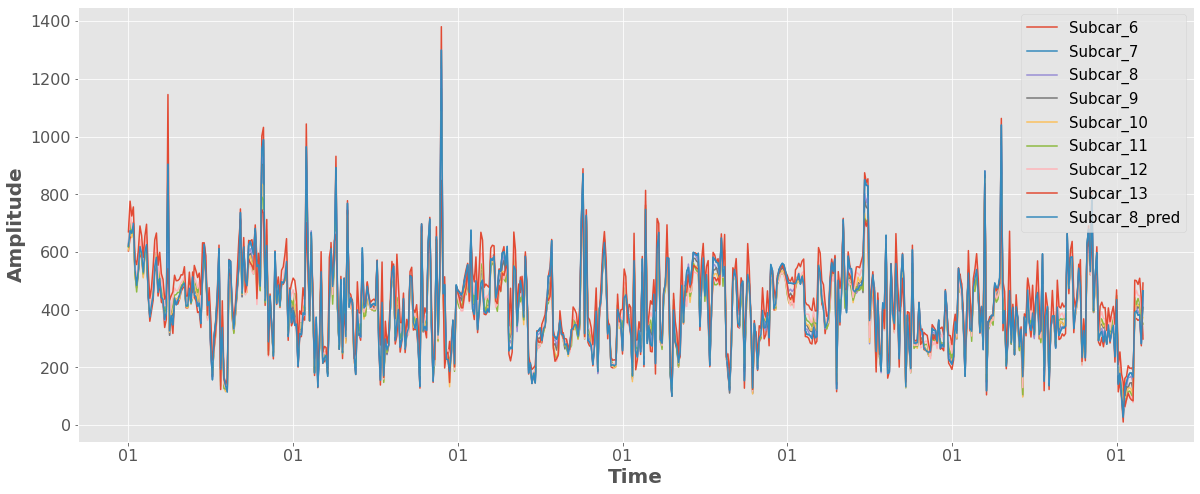

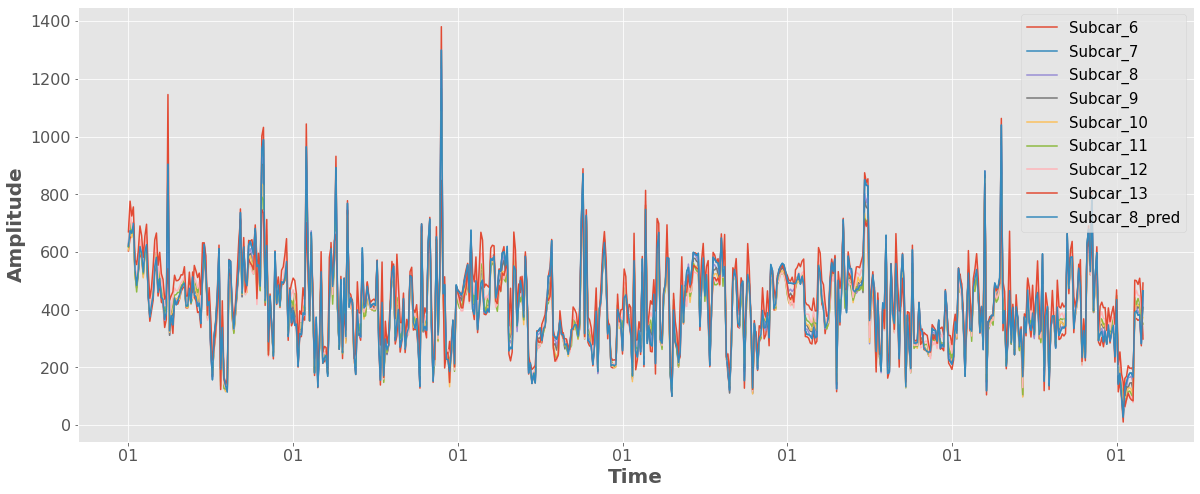

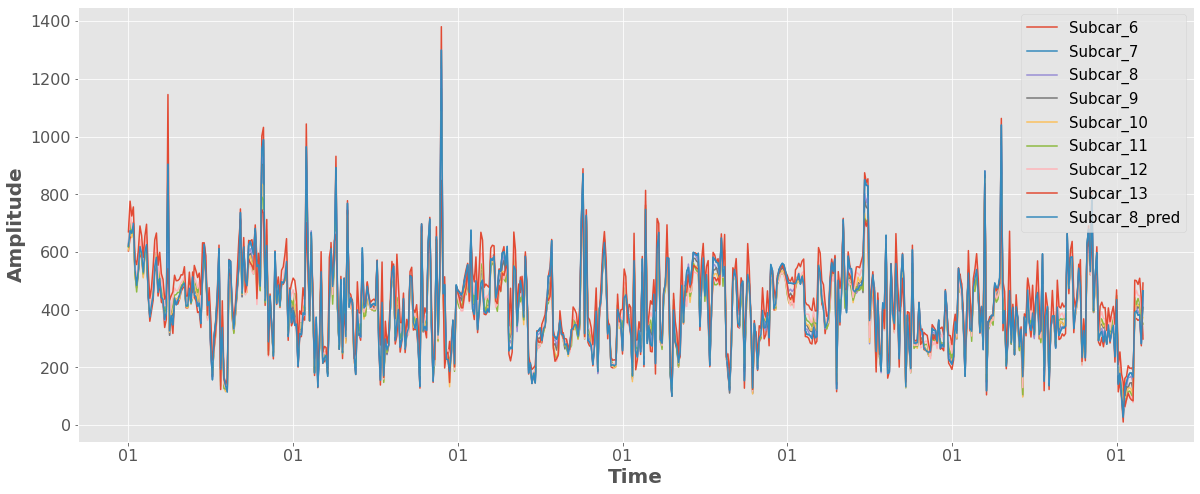

In [597]:

df_final_gru[['Subcar_8', 'Subcar_8_pred']]
df_final_gru.index = date_time[:617]
_ = df_final_gru.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
            horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/lstm_curve_standard.eps', dpi=300)

df_final_gru[['Subcar_8', 'Subcar_8_pred']]
df_final_gru.index = date_time[:617]
_ = df_final_gru.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/gru_curve_standard.eps', dpi=300)

df_final_conv[['Subcar_8', 'Subcar_8_pred']]
df_final_conv.index = date_time[:617]
_ = df_final_conv.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/conv_curve_standard.eps', dpi=300)


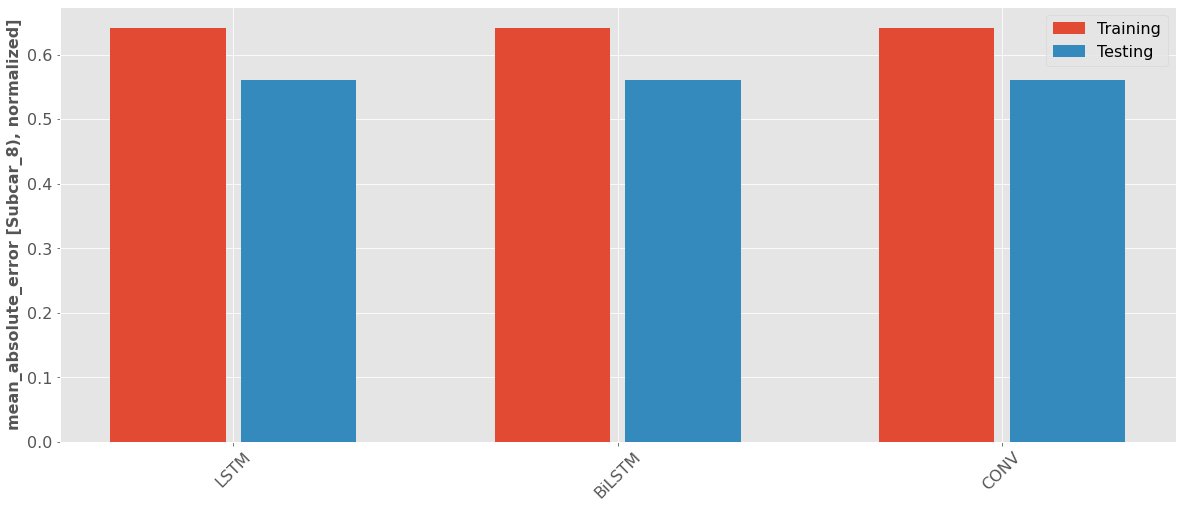

In [598]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Subcar_8), normalized]',
           fontsize=16, fontweight='bold', horizontalalignment='center')
plt.bar(x - 0.17, val_mae, width, label='Training')
plt.bar(x + 0.17, test_mae, width, label='Testing')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45, fontsize=16)
plt.yticks(fontsize=16)
_ = plt.legend(fontsize=16)
# plt.savefig('../images/bar_graph_standard.pdf', dpi=500)


In [599]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


LSTM        : 0.5610
BiLSTM      : 0.5610
CONV        : 0.5610


In [600]:
# df_final_conv[['Subcar_7', 'Subcar_7_pred']].plot()
for name, value in val_performance.items():
      print(f'{name:12s}: {value[1]:0.4f}')


LSTM        : 0.6419
BiLSTM      : 0.6419
CONV        : 0.6419
